In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns 

from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import perceptron
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

C:\Users\82109\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.linear_model.perceptron module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
train_imgs = np.load('./comp0090/fashion-train-imgs.npz')     # 28, 28, 120000
train_label = np.load('./comp0090/fashion-train-labels.npz')   # 12000, 
dev_imgs = np.load('./comp0090/fashion-dev-imgs.npz')          # 28, 28, 1000
dev_label = np.load('./comp0090/fashion-dev-labels.npz')       # 1000,
test_imgs = np.load('./comp0090/fashion-test-imgs.npz')        # 28, 28, 1000
test_label = np.load('./comp0090/fashion-test-labels.npz')     # 1000, 

print(train_imgs.shape)
print(train_label.shape)
print(dev_imgs.shape)
print(dev_label.shape)
print(test_imgs.shape)
print(test_label.shape)

(28, 28, 12000)
(12000,)
(28, 28, 1000)
(1000,)
(28, 28, 1000)
(1000,)


[ 2429  6820  6981  3079  6012  9884  9906  8273  2012  7629  5965 10857
   946  5176  9580  7940  8074  4247  6766  7154  1213  1264  6534  8997
  5950]
(25, 784)


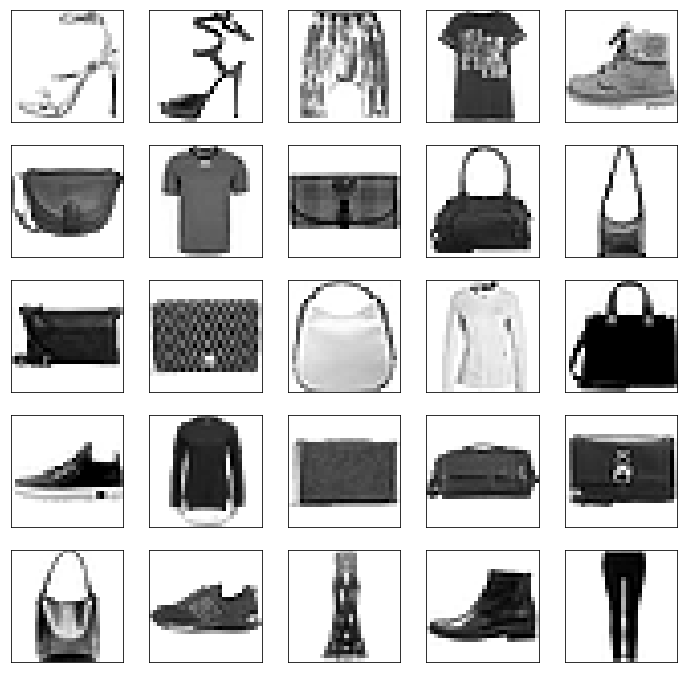

In [3]:
train_imgs_data = np.zeros((train_imgs.shape[2],train_imgs.shape[1]*train_imgs.shape[0]))
for k in range(train_imgs.shape[2]):
 index = 0;
 for j in range(28):
   for i in range(28):
     train_imgs_data[k][index] = train_imgs[j][i][k];
     index = index + 1

sample_idx = np.random.choice(np.arange(train_imgs_data.shape[0]), 25)
sample_images = train_imgs_data[sample_idx, :]
print(sample_idx)
print(sample_images.shape)
fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(12, 12))
for r in range(5):
    for c in range(5):
        ax_array[r, c].matshow(np.array(sample_images[5 * r + c].reshape((28, 28))).T,cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 

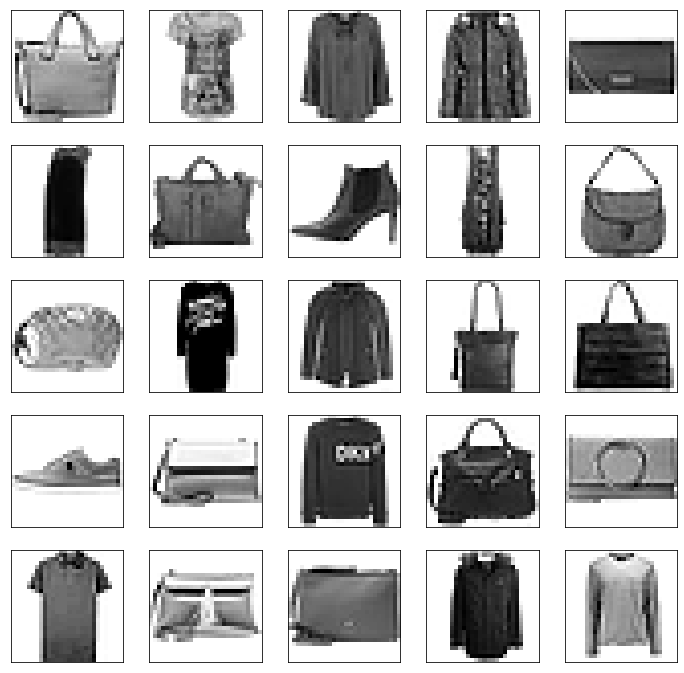

In [4]:
dev_imgs_data = np.zeros((dev_imgs.shape[2],dev_imgs.shape[1]*dev_imgs.shape[0]))
for k in range(dev_imgs.shape[2]):
 index = 0;
 for j in range(28):
   for i in range(28):
     dev_imgs_data[k][index] = dev_imgs[j][i][k];
     index = index + 1

sample_idx = np.random.choice(np.arange(dev_imgs_data.shape[0]), 25)
sample_images = dev_imgs_data[sample_idx, :]
fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(12, 12))
for r in range(5):
    for c in range(5):
        ax_array[r, c].matshow(np.array(sample_images[5 * r + c].reshape((28, 28))).T,cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 

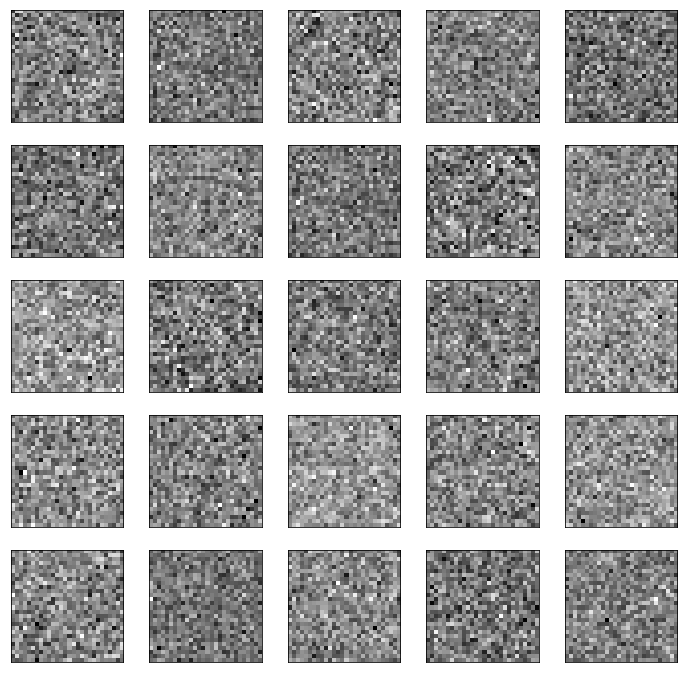

In [5]:
test_imgs_data = np.zeros((test_imgs.shape[2],test_imgs.shape[1]*test_imgs.shape[0]))
for k in range(test_imgs.shape[2]):
 index = 0;
 for j in range(28):
   for i in range(28):
     test_imgs_data[k][index] = test_imgs[j][i][k];
     index = index + 1

sample_idx = np.random.choice(np.arange(test_imgs_data.shape[0]), 25)
sample_images = test_imgs_data[sample_idx, :]
fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(12, 12))
for r in range(5):
    for c in range(5):
        ax_array[r, c].matshow(np.array(sample_images[5 * r + c].reshape((28, 28))).T,cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 

In [6]:
def sigmoid(z): #activation function
    return 1 / (1 + np.exp(-z))

def sigmoid_gradient(z): #gradient of the sigmoid function
    return np.multiply(sigmoid(z), (1 - sigmoid(z)))

def forward_propagate(X, theta1, theta2, b1, b2):
    m = X.shape[0]
    a1 = np.insert(X, 0, values=np.ones(m), axis=1) #add a bias term in the input layer
    z2 = a1 * theta1.T + b1
    a2 = np.insert(sigmoid(z2), 0, values=np.ones(m), axis=1)
    z3 = a2 * theta2.T + b2
    h = sigmoid(z3)
    return a1, z2, a2, z3, h

def backprop(theta1, theta2, b1, b2, X, y):
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    # run the feed forward propagation and get the values of each layer
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2, b1, b2)

    # Inialise the gradient of each model parameters and loss J
    J = 0 #Loss
    delta1 = np.zeros(theta1.shape) #gradient of theta1
    delta2 = np.zeros(theta2.shape) #gradient of theta2
    
    delta_b_1 = np.zeros(b1.shape) #gradient of b1
    delta_b_2 = np.zeros(b2.shape) #gradient of b2
    
    # compute the log-likelihood loss
    for i in range(m):
        first_term = np.multiply(-y[i,:].T, np.log(h[i,:]))
        second_term = np.multiply((1 - y[i,:]).T, np.log(1 - h[i,:]))
        J += np.sum(first_term - second_term)
    J = J / m

    # run backpropagation
    for t in range(m):
        a1t = a1[t, :] #input layer
        z2t = z2[t, :] #input layer times W1 and plus b1
        a2t = a2[t, :] #second layer after sigmoid function from z2t
        ht = h[t, :] #prediction
        yt = y[t, :] #label
        d3t = ht - yt #second layer difference
        z2t = np.insert(z2t, 0, values=np.ones(1))
        d2t = np.multiply((theta2.T * d3t.T).T, sigmoid_gradient(z2t)) #first layer difference

        #sum up the difference
        delta1 = delta1 + (d2t[:,1:]).T * a1t
        delta2 = delta2 + d3t.T * a2t
    
        delta_b_1 = delta_b_1 + (d2t[:,1:])
        delta_b_2 = delta_b_2 + d3t

    delta1 = delta1 / m
    delta2 = delta2 / m
    
    delta_b_1 = delta_b_1 / m
    delta_b_2 = delta_b_2 / m
    return J, delta1, delta2, delta_b_1, delta_b_2, theta1, theta2, b1, b2

In [12]:
def gradient_descent_with_momentum(input_size, hidSize, num_labels, X, Y, learning_rate, batch_size, momentum_coefficient, max_it, val_input, train_input, train_output, val_output):
    checkpoint_step = int(max_it / 100) #check the progress of training
    
    best_loss = float('+inf') #set the best loss as the maximum float number
    best_theta1 = None #set the best parameters
    best_theta2 = None
    
    best_b1 = None
    best_b2 = None
    best_epoch = 0
    
    #create an array of random term theta1, theta2
    params=(np.random.random(size = hidSize * (input_size + 1) + num_labels*(hidSize + 1)) - 0.5) * 0.24

    theta1 = np.matrix(np.reshape(params[:hidSize * (input_size + 1)], (hidSize, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidSize * (input_size + 1):],(num_labels, (hidSize + 1))))

    #initialise the vector of theta for momentum
    lastv_theta1 = np.matrix(np.zeros((hidSize, (input_size + 1))))
    lastv_theta2 = np.matrix(np.zeros((num_labels, (hidSize + 1))))

    #create an array of random term b1, b2
    paramsB=(np.random.random(size = hidSize + num_labels ) - 0.5) * 0.24
    
    b1 = np.matrix(np.reshape(paramsB[:hidSize ],(1, (hidSize))))
    b2 = np.matrix(np.reshape(paramsB[hidSize : ],(1, (num_labels))))

    #initialise the vector of bias for momentum
    lastv_b1 = np.matrix(np.zeros((1, (hidSize))))
    lastv_b2 = np.matrix(np.zeros((1, (num_labels))))

    loss_train_set = [] #record the loss of train dataset
    loss_val_set = [] #record the loss of validation dataset
    accuracy_train_set = [] #record the accuracy of prediction on training set
    accuracy_val_set = [] #record the accuracy of prediction on validation set

    for it in range(max_it): #repeat for preset number of iterations
        #select mini batch
        batchx, batchy = select_mini_batch(X, Y, batch_size)
        #do the backward propagation
        J, delta1, delta2, delta_b_1, delta_b_2, theta1, theta2, b1, b2 = backprop(theta1, theta2, b1, b2, batchx, batchy)
        J_val = backprop(theta1, theta2, b1, b2, val_input, val_output)[0]
        if J < best_loss: #if loss is smaller than the lowest loss, record the current model parameters
            best_theta1 = theta1
            best_theta2 = theta2
            
            best_b1 = b1
            best_b2 = b2
            best_epoch = it
        #gradient descent
        #update the model parameters by subtracting learning rate multiplied by gradient of the model parameter
        #if coefficient of momentum is not zero, the vector will be influential
        v_theta1 = momentum_coefficient * lastv_theta1 - learning_rate * delta1
        theta1 = theta1 + v_theta1
        lastv_theta1 = v_theta1
        
        v_theta2 = momentum_coefficient * lastv_theta2 - learning_rate * delta2
        theta2 = theta2 + v_theta2
        lastv_theta2 = v_theta2
        
        v_b1 = momentum_coefficient * lastv_b1 - learning_rate * delta_b_1
        b1 = b1 + v_b1
        lastv_b1 = v_b1
        
        v_b2 = momentum_coefficient * lastv_b2 - learning_rate * delta_b_2
        b2 = b2 + v_b2
        lastv_b2 = v_b2

        #use forward propagation to get the prediction in train and validation set with current model parameters
        h_val = forward_propagate(val_input,theta1,theta2,b1,b2)[4]
        h_train = forward_propagate(train_input,theta1,theta2,b1,b2)[4]
        
        #change the prediction to one hot format
        prediction_val = change_to_onehot(np.argmax(h_val, axis = 1), 2)
        prediction_train = change_to_onehot(np.argmax(h_train, axis = 1), 2)

        #recored the accuracy of the prediciton in train and validation set
        accuracy_val = accuracy_score(val_output, prediction_val)
        accuracy_train = accuracy_score(train_output, prediction_train)

        loss_train_set.append(J) #record the loss of train dataset
        loss_val_set.append(J_val) #record the loss of validation dataset

        accuracy_val_set.append(accuracy_val)#record the accuracy in validation set
        accuracy_train_set.append(accuracy_train) #record the accuracy in train set

        if (it + 1) % checkpoint_step == 0:
            print('[{:05}] current loss: {}'.format(it + 1, J)) #present the progress of training
    return loss_train_set, loss_val_set, best_theta1, best_theta2, best_b1, best_b2, accuracy_val_set, accuracy_train_set, best_epoch

In [16]:
def select_mini_batch(datax, datay, batchsize): # select mini batch
    dataxy = np.append(datax, datay, axis=1)
    n = dataxy.shape[0]
    permutation = list(np.random.permutation(n))
    shuffled_dataxy = dataxy[permutation, :] # shuffle all dataset
    
    batchxy = shuffled_dataxy[:batchsize, :]
    batchx = batchxy[:, :input_size]
    batchy = batchxy[:, input_size:]
    return batchx, batchy

# Other essential codes to implement two-layers MLP is provided below:
def one_hot_label(label): #change the label to one-hot format
    new_label=[]
    for i in range(label.shape[0]):
        if label[i] not in new_label:
            new_label.append(label[i])
    one_hot_encoder = np.zeros((label.shape[0],np.mat(new_label).shape[1]))

    for i in range(label.shape[0]):
        one_hot_encoder[i][label[i]] = 1
    return one_hot_encoder

def change_to_onehot(prediction,num_labels):
    one_hot = np.zeros((prediction.shape[0], num_labels))
    parameter = one_hot.shape[0]
    for i in range(parameter):
        if prediction[i] == 0:
            one_hot[i][0] = 1
            one_hot[i][1] = 0
        else:
            one_hot[i][0] = 0
            one_hot[i][1] = 1
    return one_hot

train_input = train_imgs_data #train data set
train_output = one_hot_label(train_label) #train label
val_input = dev_imgs_data #validation date set
val_output = one_hot_label(dev_label) #validation label
X = train_input
Y = train_output

In [17]:
# (a) Full-batch gradient descent without momentum
input_size = 784 #input size, which is the number of pixels in the graph
hidSize = 30 #hiden size of the first layer
num_labels = 2 #number of labels in the output
learning_rate = 1 #set the learning rate
batch_size = X.shape[0] #set the batch size ("X.shape[0]" means full-batch, "1" means SGD)
momentum_coefficient = 0 #set the coefficient of momentum ("0" means without momentum)
max_it = 100 #set the number of iterations (use 100 epochs to find good parameters)

loss_train_set, loss_val_set, best_theta1, best_theta2, best_b1, best_b2, accuracy_val_set, accuracy_train_set, best_epoch = gradient_descent_with_momentum(input_size, hidSize, num_labels, X, Y, learning_rate, batch_size, momentum_coefficient, max_it, val_input, train_input, train_output, val_output)
print("The highest accuracy of validation set is {}".format(max(accuracy_val_set)))

[00001] current loss: 2.7765359731765487
[00002] current loss: 2.7831859441912106
[00003] current loss: 2.791850674946021
[00004] current loss: 2.8147527540028223
[00005] current loss: 2.843634680146388
[00006] current loss: 2.9094750222757915
[00007] current loss: 3.00695613706775
[00008] current loss: 3.3970987584805905
[00009] current loss: 4.085342557459856
[00010] current loss: 3.865745895620642
[00011] current loss: 2.842893917166838
[00012] current loss: 2.8574491507001856
[00013] current loss: 2.916351799173357
[00014] current loss: 3.038552156361828
[00015] current loss: 3.184448796545698
[00016] current loss: 3.431434182193684
[00017] current loss: 3.7063800818264463
[00018] current loss: 4.386616948495561
[00019] current loss: 5.047106397462972
[00020] current loss: 3.9012886838502436
[00021] current loss: 3.166751336443274
[00022] current loss: 3.513034638790976
[00023] current loss: 3.6822902935397512
[00024] current loss: 4.101201949887937
[00025] current loss: 4.21431763

In [18]:
# (b) Stochastic gradient descent without momentum
input_size = 784 #input size, which is the number of pixels in the graph
hidSize = 30 #hiden size of the first layer
num_labels = 2 #number of labels in the output
learning_rate = 1 #set the learning rate
batch_size = 1 #set the batch size ("X.shape[0]" means full-batch, "1" means SGD)
momentum_coefficient = 0 #set the coefficient of momentum ("0" means without momentum)
max_it = 100 #set the number of iterations (use 100 epochs to find good parameters)

loss_train_set, loss_val_set, best_theta1, best_theta2, best_b1, best_b2, accuracy_val_set, accuracy_train_set, best_epoch = gradient_descent_with_momentum(input_size, hidSize, num_labels, X, Y, learning_rate, batch_size, momentum_coefficient, max_it,val_input,train_input,train_output,val_output)
print("The highest accuracy of validation set is {}".format(max(accuracy_val_set)))

[00001] current loss: 2.7924929348682497
[00002] current loss: 9.79162380224712
[00003] current loss: 3.2594798096262196
[00004] current loss: 2.8810490397591972
[00005] current loss: 2.7939821366508077
[00006] current loss: 5.106828393376668
[00007] current loss: 5.396399376558053
[00008] current loss: 2.9950528716181477
[00009] current loss: 2.9738368731309976
[00010] current loss: 3.6053497397512495
[00011] current loss: 4.131547758761494
[00012] current loss: 2.7735731598956916
[00013] current loss: 3.2771572456103604
[00014] current loss: 3.9019606444831405
[00015] current loss: 2.7784805055728485
[00016] current loss: 3.204224160550725
[00017] current loss: 3.8121978908162024
[00018] current loss: 4.328690716904981
[00019] current loss: 2.7881336444639913
[00020] current loss: 3.294179501522861
[00021] current loss: 4.212070530695485
[00022] current loss: 2.785893108164609
[00023] current loss: 3.1896025342055143
[00024] current loss: 3.7648762452244755
[00025] current loss: 2.78

In [19]:
# (c) Mini-batch gradient descent without momentum
input_size = 784 #input size, which is the number of pixels in the graph
hidSize = 30 #hiden size of the first layer
num_labels = 2 #number of labels in the output
learning_rate = 1 #set the learning rate
batch_size = 512 #set the batch size ("X.shape[0]" means full-batch, "1" means SGD)
momentum_coefficient = 0 #set the coefficient of momentum ("0" means without momentum)
max_it = 100 #set the number of iterations (use 100 epochs to find good parameters)

loss_train_set, loss_val_set, best_theta1,best_theta2,best_b1,best_b2,accuracy_val_set,accuracy_train_set, best_epoch = gradient_descent_with_momentum(input_size, hidSize, num_labels, X, Y, learning_rate, batch_size, momentum_coefficient, max_it,val_input,train_input,train_output,val_output)
print("The highest accuracy of validation set is {}".format(max(accuracy_val_set)))

[00001] current loss: 2.7991780251740788
[00002] current loss: 2.8140186637135747
[00003] current loss: 2.89774611942133
[00004] current loss: 3.167301354736198
[00005] current loss: 3.463342218012299
[00006] current loss: 3.18070425996852
[00007] current loss: 2.8975648374782343
[00008] current loss: 2.847967512095036
[00009] current loss: 2.967757528726891
[00010] current loss: 3.09425510491622
[00011] current loss: 3.2379824511965194
[00012] current loss: 3.4193304630124155
[00013] current loss: 3.8671848181753297
[00014] current loss: 5.582617792791565
[00015] current loss: 6.267790253925071
[00016] current loss: 2.8696093355271697
[00017] current loss: 2.880118887073501
[00018] current loss: 3.030191956450585
[00019] current loss: 3.0153473934571755
[00020] current loss: 3.2060109418469342
[00021] current loss: 3.209915583214728
[00022] current loss: 3.5112025205188906
[00023] current loss: 3.496503149700515
[00024] current loss: 4.29563940670056
[00025] current loss: 4.5018690727

In [20]:
# (d) (Full-)batch gradient descent with momentum
input_size = 784 #input size, which is the number of pixels in the graph
hidSize = 30 #hiden size of the first layer
num_labels = 2 #number of labels in the output
learning_rate = 1 #set the learning rate
batch_size = X.shape[0] #set the batch size ("X.shape[0]" means full-batch, "1" means SGD)
momentum_coefficient = 0.9 #set the coefficient of momentum ("0" means without momentum)
max_it = 100 #set the number of iterations (use 100 epochs to find good parameters)
loss_train_set, loss_val_set, best_theta1, best_theta2, best_b1,best_b2, accuracy_val_set, accuracy_train_set, best_epoch = gradient_descent_with_momentum(input_size, hidSize, num_labels, X, Y, learning_rate, batch_size, momentum_coefficient, max_it,val_input,train_input,train_output,val_output)
print("The highest accuracy of validation set is {}".format(max(accuracy_val_set)))

[00001] current loss: 2.7938372756758345
[00002] current loss: 2.856997682546028
[00003] current loss: 2.8894676823179513
[00004] current loss: 2.8362832668174027
[00005] current loss: 3.066355396118478
[00006] current loss: 3.70529880327461
[00007] current loss: 4.77150950358534
[00008] current loss: 6.440897807026591
[00009] current loss: 8.198514901306002
[00010] current loss: 9.567539515266452
[00011] current loss: 5.158256943684023
[00012] current loss: 8.164080191912626
[00013] current loss: 4.141730126309942
[00014] current loss: 4.195165850195751
[00015] current loss: 3.7788759627830912
[00016] current loss: 3.900479198798238
[00017] current loss: 5.226534054705917
[00018] current loss: 6.130232751311667
[00019] current loss: 6.667612330770872
[00020] current loss: 7.124991902907335
[00021] current loss: 7.379651806724026
[00022] current loss: 7.473458464815365
[00023] current loss: 7.671738713465182
[00024] current loss: 8.053552431080416
[00025] current loss: 8.48838107748440

In [21]:
# (e) Stochastic gradient descent with momentum
input_size = 784 #input size, which is the number of pixels in the graph
hidSize = 30 #hiden size of the first layer
num_labels = 2 #number of labels in the output
learning_rate = 1 #set the learning rate
batch_size = 1 #set the batch size ("X.shape[0]" means full-batch, "1" means SGD)
momentum_coefficient = 0.9 #set the coefficient of momentum ("0" means without momentum)
max_it = 100 #set the number of iterations (use 100 epochs to find good parameters)

loss_train_set, loss_val_set, best_theta1, best_theta2, best_b1, best_b2, accuracy_val_set, accuracy_train_set, best_epoch = gradient_descent_with_momentum(input_size, hidSize, num_labels, X, Y, learning_rate, batch_size, momentum_coefficient, max_it,val_input,train_input,train_output,val_output)
print("The highest accuracy of validation set is {}".format(max(accuracy_val_set)))

[00001] current loss: 2.781196553581877
[00002] current loss: 11.847546749661596
[00003] current loss: 2.9253082241537185
[00004] current loss: 6.694304463815478
[00005] current loss: 11.629414308892555
[00006] current loss: 16.183997224362074
[00007] current loss: 14.113737877930703
[00008] current loss: 4.975070041543507
[00009] current loss: 2.778674706796534
[00010] current loss: 6.194173144719002
[00011] current loss: 7.478676979025125
[00012] current loss: 8.791313085778691
[00013] current loss: 10.004480059471522
[00014] current loss: 11.112194904076702
[00015] current loss: 8.21388102103499
[00016] current loss: 5.8007805734825375
[00017] current loss: 2.8128513355469424
[00018] current loss: 7.836758097412962
[00019] current loss: 14.336419450992729
[00020] current loss: 16.258018272217925
[00021] current loss: 17.989981506561943
[00022] current loss: 19.549456782661483
[00023] current loss: 20.953334391527925
[00024] current loss: 18.21737936226484
[00025] current loss: 11.76

<ipython-input-6-9ef27b25f59e>:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-z))


[00038] current loss: 2.8671320346409415
[00039] current loss: 2.9898421870400864
[00040] current loss: 3.9305963260174823
[00041] current loss: 5.758742826797815
[00042] current loss: 7.897757971365273
[00043] current loss: 10.03973226149203
[00044] current loss: 12.006673981246832
[00045] current loss: 13.772537896669018
[00046] current loss: 11.424288477869467
[00047] current loss: 5.524612392898054
[00048] current loss: 2.7818298707648106
[00049] current loss: 3.6236234451959377
[00050] current loss: 6.184028780656162
[00051] current loss: 9.269102729574225
[00052] current loss: 8.087151346953455
[00053] current loss: 7.19069948646815
[00054] current loss: 3.440664630302013
[00055] current loss: 5.285371398914517
[00056] current loss: 7.923507130654707
[00057] current loss: 6.670051241939602
[00058] current loss: 3.0385737978088354
[00059] current loss: 3.1546341500853416
[00060] current loss: 3.1936729583328556
[00061] current loss: 3.854624185778542
[00062] current loss: 2.867818

In [22]:
# (f) Mini-batch gradient descent with momentum
input_size = 784 #input size, which is the number of pixels in the graph
hidSize = 30 #hiden size of the first layer
num_labels = 2 #number of labels in the output
learning_rate = 1 #set the learning rate
batch_size = 512 #set the batch size ("X.shape[0]" means full-batch, "1" means SGD)
momentum_coefficient = 0.9 #set the coefficient of momentum ("0" means without momentum)
max_it = 100 #set the number of iterations (use 100 epochs to find good parameters)

loss_train_set, loss_val_set, best_theta1,best_theta2, best_b1, best_b2, accuracy_val_set, accuracy_train_set, best_epoch = gradient_descent_with_momentum(input_size, hidSize, num_labels, X, Y, learning_rate, batch_size, momentum_coefficient, max_it,val_input,train_input,train_output,val_output)
print("The highest accuracy of validation set is {}".format(max(accuracy_val_set)))

[00001] current loss: 2.795427068125979
[00002] current loss: 2.8276779542448676
[00003] current loss: 2.888911562215429
[00004] current loss: 2.890509679691335
[00005] current loss: 3.0612497348728795
[00006] current loss: 3.6569463617942795
[00007] current loss: 4.676980528387685
[00008] current loss: 6.04917364541824
[00009] current loss: 7.091942429168258
[00010] current loss: 8.303344588387617
[00011] current loss: 9.619709996019877
[00012] current loss: 6.420922263773418
[00013] current loss: 4.713288607471879
[00014] current loss: 5.795001115158564
[00015] current loss: 6.1283207338671035
[00016] current loss: 5.7807689849651975
[00017] current loss: 6.424201223467527
[00018] current loss: 7.040497264268781
[00019] current loss: 7.266624127362275
[00020] current loss: 7.69306723073606
[00021] current loss: 7.728045035358315
[00022] current loss: 8.62119069918142
[00023] current loss: 9.421143594325937
[00024] current loss: 9.413726187178717
[00025] current loss: 9.89050749141442

In [ ]:
# Establish a "grid" based on intuitions regarding the model.
learningrates = [1, 0.1, 0.01, 0.001]
batchsizes = [32, 64, 128, 256, 512, 1024, X.shape[0]]
momentums = [0.9, 0.5, 0.2, 0.0]
good_learningrate = 1
good_batchsize = X.shape[0]
good_momentum = 0
best_accuracy = 0

for learningrate in learningrates:
    for batchsize in batchsizes:
        for momentum in momentums:
            # Train and evaluate the model with the given parameters on the validation set.
            input_size = 784 #input size, which is the number of pixels in the graph
            hidSize = 30 #hiden size of the first layer
            num_labels = 2 #number of labels in the output
            learning_rate = learningrate
            batch_size = batchsize
            momentum_coefficient = momentum
            max_it = 100 #set the number of iterations (use 100 epoches to find good parameters)
            accuracy_val_set = gradient_descent_with_momentum(input_size, hidSize, num_labels, X, Y, learning_rate, batch_size, momentum_coefficient, max_it,val_input,train_input,train_output,val_output)[6]

            if max(accuracy_val_set) > best_accuracy:
                best_accuracy = max(accuracy_val_set)
                good_learningrate = learningrate
                good_batchsize = batchsize
                good_momentum = momentum

print("The good learning rate is {}".format(good_learningrate))
print("The good batch size is {}".format(good_batchsize))
print("The good momentum coefficient is {}".format(good_momentum))

However, there is a potential problem that "learning rate = 1" may not be better than smaller rate
such as "learning rate = 0.1".
First, as shown in figures below, bigger learning rate has stronger vibrations for accuracy growth
because the weight and bias changing step in each epoch is large. After model trend to convergence,
the accuracy is also more unstable than smaller learning rate. Therefore, even the accuracy from
model with higher learning rate is better, it could possibly caused by occasional error(a vibration)
since our evaluation criterion is just the highest accuracy of validation dataset.
Secoond, lower learning rate could cause a slow speed trend to convergence which means it is
possible that the accuracy of model with lower learning rate is worse because it has not reach to
convergence.(Although it is obvious to say both model have reached convergence in this situation,
this kind of possibility still exist in other cases)

In [24]:
input_size = 784 #input size, which is the number of pixels in the graph
hidSize = 30 #hiden size of the first layer
num_labels = 2 #number of labels in the output
learning_rate_0 = 1 #set the initial learning rate
decay_rate = 0.97 #set the decay rate (this will cause a final 0.05 learning rate)
batch_size = 512 #set the batch size ("X.shape[0]" means full-batch, "1" means SGD)
momentum_coefficient = 0.9 #set the coefficient of momentum ("0" means without momentum)
max_it = 100 #set the number of iterations (use 100 epoches to find good parameters)

def gradient_descent_LRdecay(input_size, hidSize, num_labels, X, Y, learning_rate_0, decay_rate, batch_size, momentum_coefficient, max_it, val_input, train_input, train_output, val_output):
    checkpoint_step = int(max_it / 100) #check the progress of training
    
    best_loss = float('+inf') #set the best loss as the maximum float number
    best_theta1 = None #set the best parameters
    best_theta2 = None

    best_b1 = None
    best_b2 = None
    best_epoch = 0

    #create an array of random term theta1, theta2
    params=(np.random.random(size = hidSize * (input_size + 1) + num_labels*(hidSize + 1)) - 0.5) * 0.24
    theta1 = np.matrix(np.reshape(params[:hidSize * (input_size + 1)],(hidSize, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidSize * (input_size + 1):],(num_labels, (hidSize + 1))))

    #initialise the vector of theta for momentum
    lastv_theta1 = np.matrix(np.zeros((hidSize, (input_size + 1))))
    lastv_theta2 = np.matrix(np.zeros((num_labels, (hidSize + 1))))

    #create an array of random term b1, b2
    paramsB = (np.random.random(size = hidSize + num_labels ) - 0.5) * 0.24
    b1 = np.matrix(np.reshape(paramsB[:hidSize ],(1, (hidSize))))
    b2 = np.matrix(np.reshape(paramsB[hidSize : ],(1, (num_labels))))

    #initialise the vector of bias for momentum
    lastv_b1 = np.matrix(np.zeros((1, (hidSize))))
    lastv_b2 = np.matrix(np.zeros((1, (num_labels))))

    loss_train_set = [] #record the loss of train dataset
    loss_val_set = [] #record the loss of validation dataset
    
    accuracy_train_set = [] #record the accuracy of prediction on training set
    accuracy_val_set = [] #record the accuracy of prediction on validation set

    for it in range(max_it): #repeat for preset number of iterations
        #select mini batch
        batchx, batchy = select_mini_batch(X, Y, batch_size)

        #do the backward propagation
        J, delta1, delta2, delta_b_1, delta_b_2, theta1, theta2, b1, b2 = backprop(theta1, theta2, b1, b2, batchx, batchy)
        J_val = backprop(theta1, theta2, b1, b2, val_input, val_output)[0]
        if J < best_loss: #if loss is smaller than the lowest loss, record the current model parameters
            best_theta1 = theta1
            best_theta2 = theta2
            
            best_b1 = b1
            best_b2 = b2
            best_epoch = it
        #gradient descent
        #update learning rate first
        learning_rate = learning_rate_0 * pow(decay_rate, it)

        #update the model parameters by subtracting learning rate multiplied by gradient of the model parameter
        #if coefficient of momentum is not zero, the vector will influential
        v_theta1 = momentum_coefficient * lastv_theta1 - learning_rate * delta1
        theta1 = theta1 + v_theta1
        lastv_theta1 = v_theta1

        v_theta2 = momentum_coefficient * lastv_theta2 - learning_rate * delta2
        theta2 = theta2 + v_theta2
        lastv_theta2 = v_theta2

        v_b1 = momentum_coefficient * lastv_b1 - learning_rate * delta_b_1
        b1 = b1 + v_b1
        lastv_b1 = v_b1

        v_b2 = momentum_coefficient * lastv_b2 - learning_rate * delta_b_2
        b2 = b2 + v_b2
        lastv_b2 = v_b2

        #use forward propagation to get the prediction in train and validation set with current model parameters
        h_val = forward_propagate(val_input,theta1,theta2,b1,b2)[4]
        h_train = forward_propagate(train_input,theta1,theta2,b1,b2)[4]

        #change the prediction to one hot format
        prediction_val = change_to_onehot(np.argmax(h_val,axis=1),2)
        prediction_train = change_to_onehot(np.argmax(h_train,axis=1),2)

        #recored the accuracy of the prediciton in train and validation set
        accuracy_val = accuracy_score(val_output, prediction_val)
        accuracy_train = accuracy_score(train_output, prediction_train)

        loss_train_set.append(J) #record the loss of train dataset
        loss_val_set.append(J_val) #record the loss of validation dataset

        accuracy_val_set.append(accuracy_val)#record the accuracy in validation set
        accuracy_train_set.append(accuracy_train) #record the accuracy in train set
        if (it + 1) % checkpoint_step == 0:
            print('[{:05}] current loss: {}'.format(it + 1, J)) #present the progress of training
    return loss_train_set, loss_val_set, best_theta1, best_theta2, best_b1, best_b2, accuracy_val_set, accuracy_train_set, best_epoch

loss_train_set, loss_val_set, best_theta1, best_theta2, best_b1, best_b2, accuracy_val_set, accuracy_train_set, best_epoch = gradient_descent_LRdecay(input_size, hidSize, num_labels, X, Y, learning_rate_0, decay_rate, batch_size, momentum_coefficient, max_it,val_input,train_input,train_output,val_output)
print("The highest accuracy of validataion set is {}".format(max(accuracy_val_set)))

[00001] current loss: 2.7957634554604667
[00002] current loss: 2.8966408042503766
[00003] current loss: 2.8062198229863586
[00004] current loss: 2.8121437552944992
[00005] current loss: 2.960194620415157
[00006] current loss: 3.257893211745601
[00007] current loss: 3.882307405835809
[00008] current loss: 4.960540036407783
[00009] current loss: 6.264213091179771
[00010] current loss: 7.405738300778183
[00011] current loss: 8.593302745438935
[00012] current loss: 8.985208704715623
[00013] current loss: 10.269639203758027
[00014] current loss: 10.34847726394831
[00015] current loss: 9.403134826762109
[00016] current loss: 8.991911288318317
[00017] current loss: 9.014781091084954
[00018] current loss: 9.374223585095395
[00019] current loss: 9.826817625620055
[00020] current loss: 10.457785239675676
[00021] current loss: 10.806810206367128
[00022] current loss: 10.933748744584001
[00023] current loss: 11.229375851201308
[00024] current loss: 11.607920225435436
[00025] current loss: 11.18866

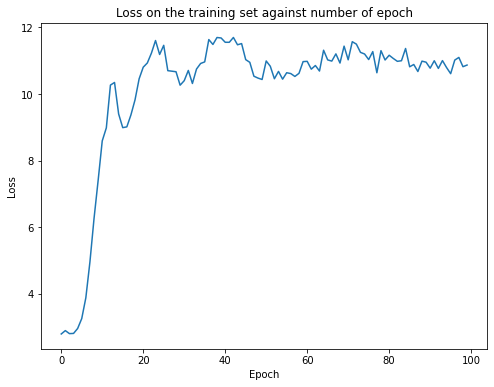

In [26]:
def plot_loss_train_curve(logs):
    fig = plt.figure(figsize = (8, 6))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Loss on the training set against number of epoch')
    plt.plot(logs)
    plt.show()
plot_loss_train_curve(loss_train_set)

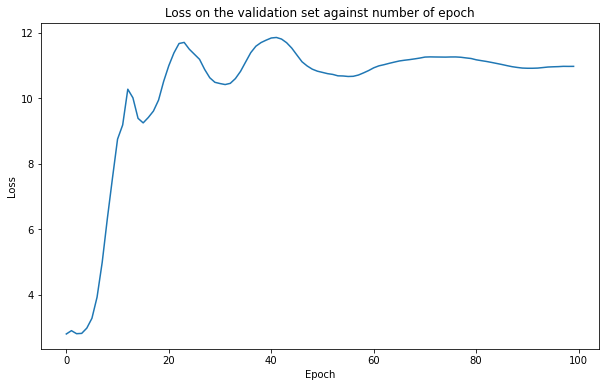

In [27]:
def plot_loss_val_curve(logs):
    fig = plt.figure(figsize = (10, 6))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.title('Loss on the validation set against number of epoch')
    plt.plot(logs)
    plt.show()
plot_loss_val_curve(loss_val_set)

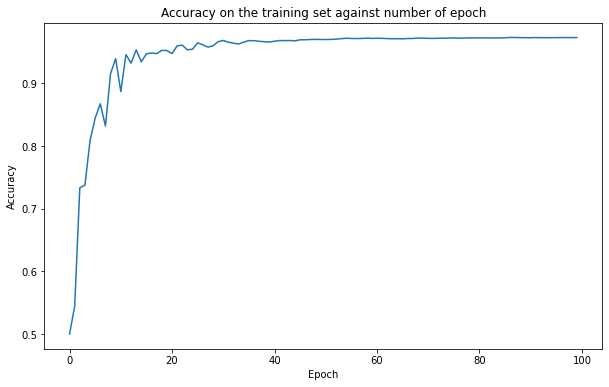

In [28]:
def plot_accuracy_train_set_curve(logs):
    fig = plt.figure(figsize = (10, 6))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Accuracy on the training set against number of epoch')
    plt.plot(logs)
    plt.show()
plot_accuracy_train_set_curve(accuracy_train_set)

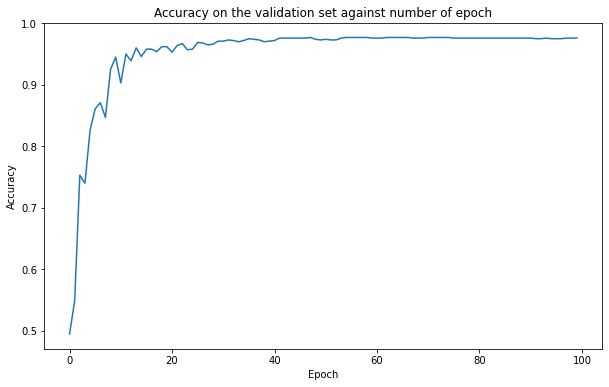

In [29]:
def plot_accuracy_val_set_curve(logs):
    fig = plt.figure(figsize = (10, 6))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.title('Accuracy on the validation set against number of epoch')
    plt.plot(logs)
    plt.show()
plot_accuracy_val_set_curve(accuracy_val_set)

In [30]:
print("The highest accuracy on the validation set is {}: ".format(max(accuracy_val_set)))
indexbest = accuracy_val_set.index(max(accuracy_val_set))
print("The epoch of highest accuracy on validation set is {}: ".format(indexbest + 1))
print("The accuracy on the train set in this epoch is {}: ".format(accuracy_train_set[indexbest]))

The highest accuracy on the validation set is 0.977: 
The epoch of highest accuracy on validation set is 48: 
The accuracy on the train set in this epoch is 0.9700833333333333: 
